# Guaranteed Completion of Complex Tasks via Temporal Logic Trees and Hamilton-Jacobi Reachability

## Setup

**Install dependencies**
```bash
sudo apt install ffmpeg
pip install -U pip
# Requires CUDA 12. There exists CPU-based JAX, check their website
pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install -e . # Installs pyspect. Must be done in root of project
pip install -U numpy matplotlib plotly kaleido tqdm moviepy scikit-image ipywidgets nbformat ipympl kaleido
```

In [1]:
%matplotlib ipympl

import numpy as np
import numpy.lib.stride_tricks as st
import matplotlib.pyplot as plt
import hj_reachability as hj
import hj_reachability.shapes as shp
import pyspect as ps
import plotly.graph_objects as go
import skimage.io as sio

from IPython.display import Image
from ipywidgets import interact, IntSlider
from functools import partial, wraps

import numpy as np
import matplotlib.pyplot as plt

In [2]:
BACKGROUND_PATH = 'Eskilstuna Intersection.png'

reach_dynamics = hj.systems.Bicycle5D(min_steer=-5*np.pi/4, 
                                      max_steer=+5*np.pi/4,
                                      min_accel=-0.4,
                                      max_accel=+0.4).with_mode('reach')

min_bounds = np.array([0.0, 0.0, -np.pi, -np.pi/5, +0.1])
max_bounds = np.array([8.0, 6.0, +np.pi, +np.pi/5, +1.1])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (61, 46, 31, 7, 11),
                                                               periodic_dims=2)

X, Y, A, D, V = range(grid.ndim)

print('dx =', grid.spacings[0], 
      'dy =', grid.spacings[1],
      'da =', grid.spacings[2],
      'dv =', grid.spacings[4])

dx = 0.13333334 dy = 0.13333334 da = 0.20268339 dv = 0.1


In [3]:
def auto_ax(f):
    @wraps(f)
    def wrapper(*args, ax: plt.Axes = None, **kwargs):
        if ax is None:
            _, ax = plt.subplots()
        kwargs.update(ax=ax)
        return f(*args, **kwargs)
    return wrapper

@auto_ax
def plot_im(im, *, ax, transpose=True, **kwargs):
    im = np.where(im, 0.5, np.nan)
    if transpose:
        im = np.transpose(im)
    kwargs.setdefault('cmap', 'Blues')
    kwargs.setdefault('aspect', 'auto')
    return [ax.imshow(im, vmin=0, vmax=1, origin='lower', **kwargs)]

@auto_ax
def plot_set(vf, **kwargs):
    kwargs.setdefault('aspect', 'equal')
    return plot_im(vf <= 0, **kwargs)

@auto_ax
def plot_set_many(*pairs, **kwargs):
    out = []
    f = lambda x: x if isinstance(x, tuple) else (x, {})
    for vf, kw in map(f, pairs):
        out += plot_set(vf, **kw, **kwargs)
    return out

def new_map(*pairs, **kwargs):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9*4/3, 9))
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    background = plt.imread(BACKGROUND_PATH)
    ax.imshow(background, extent=extent)
    plot_set_many(*pairs, ax=ax, alpha=0.9, extent=extent, **kwargs)
    fig.tight_layout()
    return fig

In [4]:
def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

def interact_scenario(times, *pairs):
    fig, ax = plt.figure(), plt.gca()
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis('off')
    ax.invert_yaxis()
    interaction = partial(interact, 
                        #   yaw_idx=IntSlider(0, min=0, max=grid.shape[2]-1),
                          vel_idx=IntSlider(0, min=0, max=grid.shape[4]-1),
                          time_idx=IntSlider(0, min=0, max=len(times)-1))
    def render_frame(# yaw_idx, 
                     vel_idx, 
                     time_idx):
        # print('yaw:', grid.coordinate_vectors[2][yaw_idx] * 180/np.pi)
        print('vel:', grid.coordinate_vectors[4][vel_idx])
        print('t:', times[time_idx])
        ax.clear()
        background = plt.imread(BACKGROUND_PATH)
        ax.imshow(background, extent=extent)
        for cmap, vf in pairs:
            cmap = plt.get_cmap(cmap)
            if not shp.is_invariant(grid, times, vf):
                vf = vf[time_idx, :, :, :, :, vel_idx]
            vf = shp.project_onto(vf, 0, 1)
            plot_set(vf, ax=ax, alpha=0.9, cmap=cmap, extent=extent)
            # ix, iy = np.unravel_index(vf.argmin(), vf.shape)
            # x = grid.coordinate_vectors[0][ix]
            # y = grid.coordinate_vectors[1][iy]
            # a = grid.coordinate_vectors[2][yaw_idx]
            # if vf[ix, iy] <= 0:
            #     plot_arrow(ax, (x, y), a, color=cmap(0.75))
        fig.tight_layout()
        return fig
    return interaction, render_frame

def interact_tubes_time(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[times[0]:times[-1]:complex(0, len(times)),
                            min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=times[0]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            vf = shp.project_onto(values, 0, 1, 2)
            if time_idx is not None and time_idx < len(times)-1:
                vf[time_idx+1:] = 1

            data += [
                go.Isosurface(
                    x=meshgrid[1].flatten(),
                    y=meshgrid[2].flatten(),
                    z=meshgrid[0].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='t [s]',
                                    aspectratio=dict(x=1, y=3/4, z=3/4)),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes_axis(times, *triplets, axis=2, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1]),
                            min_bounds[axis]:max_bounds[axis]:complex(0, grid.shape[axis])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=min_bounds[axis]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            axes = 1, 2, axis+1
            vf = (shp.project_onto(values, *axes) if time_idx is None else
                  shp.project_onto(values, 0, *axes)[time_idx])

            data += [
                go.Isosurface(
                    x=meshgrid[0].flatten(),
                    y=meshgrid[1].flatten(),
                    z=meshgrid[2].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title=['Yaw [rad]', 'Delta [rad]', 'Vel [m/s]'][axis-2]),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes(*args, axis=None, **kwargs):
    return (interact_tubes_time(*args, **kwargs) if axis is None else
            interact_tubes_axis(*args, **kwargs, axis=axis))

def sphere_to_cartesian(r, theta, phi):
    theta *= np.pi/180
    phi *= np.pi/180
    return dict(x=r*np.sin(theta)*np.cos(phi),
                y=r*np.sin(theta)*np.sin(phi),
                z=r*np.cos(theta))

EYE_W   = sphere_to_cartesian(2.2, 45, -90 - 90)
EYE_WSW = sphere_to_cartesian(2.2, 70, -90 - 70)
EYE_SW  = sphere_to_cartesian(2.5, 60, -90 - 45)
EYE_SSW = sphere_to_cartesian(2.2, 70, -90 - 20)
EYE_S   = sphere_to_cartesian(2.5, 45, -90 + 0)
EYE_SSE = sphere_to_cartesian(2.2, 70, -90 + 20)
EYE_SE  = sphere_to_cartesian(2.5, 60, -90 + 45)
EYE_ESE = sphere_to_cartesian(2.2, 70, -90 + 70)
EYE_E   = sphere_to_cartesian(2.2, 45, -90 + 90)

## Implementing `pyspect`

In [5]:
class Set(ps.Set):

    vf: np.ndarray
    grid: hj.Grid
    timeline: np.ndarray
    dynamics: hj.Dynamics

    solver_settings = hj.SolverSettings.with_accuracy("low")
    
    def __init__(self, dynamics, grid, timeline, vf, **kwargs):
        super().__init__(**kwargs)

        self.dynamics = dynamics
        self.timeline = timeline
        self.grid = grid
        self.vf = vf

    def copy(self):
        return Set(self.dynamics, 
                   self.grid, 
                   self.timeline.copy(), 
                   self.vf.copy(), 
                   approx=self.approx)
    
    @classmethod
    def empty(self):
        return np.ones(self.grid.shape)
    
    def is_empty(self):
        return np.all(0 < self.vf)
    
    def membership(self, point):
        idx = self.grid.nearest_index(point)
        return self.vf[idx] <= 0
    
    def complement(self):
        s = super().complement()
        s.vf = np.asarray(-s.vf)
        return s
    
    def union(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().union(other)
        s.vf = np.asarray(np.minimum(self.vf, other.vf))
        return s
    
    def intersect(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().intersect(other)
        s.vf = np.asarray(np.maximum(self.vf, other.vf))
        return s
    
    def reach(self, constraints=None):
        s = super().reach(constraints)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      self.vf,
                      constraints if constraints is None else constraints.vf)
        s.vf = np.flip(np.asarray(vf), axis=0)
        return s

    def rci(self):
        s = super().rci()
        s._make_tube()
        target = np.ones_like(s.vf)
        target[-1, ...] = s.vf[-1, ...]
        constraint = s.vf
        vf = hj.solver(self.solver_settings,
                       self.dynamics,
                       self.grid,
                       self.timeline,
                       target,
                       constraint)
        s.vf = np.asarray(np.flip(vf, axis=0))
        return s

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))

def find_windows(mask, N=1, M=None):
    """Find the indices of windows where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    assert N <= len(mask)
    window_view = st.sliding_window_view(mask, window_shape=N)
    ix, = np.where(N == np.sum(window_view, axis=1))
    if M is not None:
        assert M <= len(mask)
        assert N < M
        window_view = st.sliding_window_view(mask, window_shape=M)
        jx = ix[ix + M <= len(mask)]
        iix, = np.where(np.sum(window_view[jx], axis=1) < M)
        ix = ix[iix]
    return ix

def earliest_window(mask, N=1, M=None):
    """Find the first window where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    windows = find_windows(mask, N, M)
    if len(windows) == 0:
        return np.array([], int)
    i = windows[0] # Earliest window
    mask = mask[i:] if M is None else mask[i:i+M]
    for j, n in enumerate(mask.cumsum()[N-1:]):
        if n != j + N:
            break
    return np.arange(i, i+n)

def nearest_index(grid, x):
    x = np.array(x)
    # assert (x >= min_bounds).all() and (x <= max_bounds).all(), f'Point {x} is out of bounds'
    ix = np.array(grid.nearest_index(x), int)
    ix = np.where(ix >= grid.shape, np.array(grid.shape)-1, ix)
    return tuple(ix)

def position(grid, ix):
    return np.array([grid.coordinate_vectors[n][ix[n]] for n in range(grid.ndim)])

def spatial_deriv(grid, vf, ix):
    spatial_deriv = []

    for axis in range(len(ix)):
        
        ix_nxt = list(ix)
        ix_nxt[axis] += 1
        ix_nxt = tuple(ix_nxt)

        ix_prv = list(ix)
        ix_prv[axis] -= 1
        ix_prv = tuple(ix_prv)

        sign = np.sign(vf[ix])

        if ix[axis] == 0:
            leftv = (vf[ix_nxt[:axis] + (-1,) + ix_nxt[axis+1:]] if grid._is_periodic_dim[axis] else 
                      vf[ix] + sign*np.abs(vf[ix_nxt] - vf[ix]))
            rightv = vf[ix_nxt]
        elif ix[axis] == grid.shape[axis] - 1:
            leftv = vf[ix_prv]
            rightv = (vf[ix_prv[:axis] + (0,) + ix_prv[axis+1:]] if grid._is_periodic_dim[axis] else 
                      vf[ix] + sign*np.abs(vf[ix] - vf[ix_prv]))
        else:
            leftv = vf[ix_prv]
            rightv = vf[ix_nxt]

        left_dx = (vf[ix] - leftv) / grid.spacings[axis]
        right_dx = (rightv - vf[ix]) / grid.spacings[axis]
        spatial_deriv.append((left_dx + right_dx) / 2)

    return np.array(spatial_deriv)

def walk(dynamics, grid, timeline, vf, x0):

    nx = grid.ndim
    nu = dynamics.control_space.ndim
    nd = dynamics.disturbance_space.ndim
    out = np.zeros((len(timeline), 1 + 1 + nx + nu + nd))

    x = np.array(x0)
    ix = nearest_index(grid, x)
    window = earliest_window(vf[(...,) + ix] <= 0)
    assert window.size > 0, 'Initial state is not inside the level set'
    
    i0 = window[0]
    timeline = timeline[i0:]
    vf = vf[i0:]

    for i, t in enumerate(timeline):
        
        v = vf[(i, *ix)]
        if v > 0:
            break

        dvdx = spatial_deriv(grid, vf[i], ix)
        u, d = dynamics.optimal_control_and_disturbance(x, t, dvdx)
        u, d = map(np.array, (u, d))

        out[i, :] = [t, v, *x, *u, *d]

        if i+1 < len(timeline):
            f = dynamics.open_loop_dynamics(x, t)
            g = dynamics.control_jacobian(x, t)
            w = dynamics.disturbance_jacobian(x, t)
            
            print(i, x, u)
            x += (timeline[i+1] - t) * np.array(f + g @ u + w @ d)
            ix = nearest_index(grid, x)

    return out[:i]

def lrcs(dynamics, grid, dt, vf, x, i):
    # these are invariant wrt t
    f = dynamics.open_loop_dynamics(x, 0)
    g = dynamics.control_jacobian(x, 0)

    ix = nearest_index(grid, x)
    dvdx = spatial_deriv(grid, vf[i], ix)
    
    a = np.array(vf[(i+1, *ix)] + dt*(dvdx.T @ f))
    b = np.array(dt*(dvdx.T @ g))
    return a, b


In [6]:
def env(timeline):
    SX, SY = grid.domain.hi[0] - grid.domain.lo[0], grid.domain.hi[1] - grid.domain.lo[1]

    print('Creating speed limits')
    limit_30 =  Set(reach_dynamics, grid, timeline, shp.rectangle(grid, axes=V, target_min=0.3, target_max=0.6))
    limit_50 =  Set(reach_dynamics, grid, timeline, shp.rectangle(grid, axes=V, target_min=0.4, target_max=1.0))

    print('Creating road geometries')
    intersection_geometry = Set(reach_dynamics, grid, timeline,
                                shp.intersection(shp.hyperplane(grid, normal=[-1, 1], offset=[SX * 4.60/8, SY * 2.67/6]),
                                                shp.hyperplane(grid, normal=[1, 1],  offset=[SX * 6.40/8, SY * 2.67/6]),
                                                shp.rectangle(grid, 
                                                            target_min=[SX * 4.20/8, SY * 1.20/6], 
                                                            target_max=[SX * 6.87/8, SY * 3.04/6])))
    kyrkogatan_left_geometry  = Set(reach_dynamics, grid, timeline,
                                    shp.union(shp.rectangle(grid, 
                                                            target_min=[SX * 0.00/8, SY * 1.85/6, +np.pi - np.pi/5], 
                                                            target_max=[SX * 5.33/8, SY * 2.37/6, -np.pi + np.pi/5]),
                                            shp.rectangle(grid, 
                                                            target_min=[SX * 6.00/8, SY * 1.70/6, +np.pi - np.pi/5], 
                                                            target_max=[SX * 8.00/8, SY * 2.24/6, -np.pi + np.pi/5]))).union(intersection_geometry)
    kyrkogatan_right_geometry = Set(reach_dynamics, grid, timeline,
                                    shp.union(shp.rectangle(grid, 
                                                            target_min=[SX * 0.00/8, SY * 1.20/6, -np.pi/5],
                                                            target_max=[SX * 5.33/8, SY * 1.84/6, +np.pi/5]),
                                            shp.rectangle(grid, 
                                                            target_min=[SX * 6.00/8, SY * 1.20/6, -np.pi/5],
                                                            target_max=[SX * 8.00/8, SY * 1.73/6, +np.pi/5]))).union(intersection_geometry)
    nygatan_down_geometry = Set(reach_dynamics, grid, timeline,
                                shp.union(shp.rectangle(grid, 
                                                        target_min=[SX * 4.94/8, SY * 2.26/6, -np.pi/2 - np.pi/5],
                                                        target_max=[SX * 5.53/8, SY * 6.00/6, -np.pi/2 + np.pi/5]),
                                        shp.rectangle(grid, 
                                                        target_min=[SX * 5.07/8, SY * 0.00/6, -np.pi/2 - np.pi/5],
                                                        target_max=[SX * 5.47/8, SY * 1.60/6, -np.pi/2 + np.pi/5]))).union(intersection_geometry)
    nygatan_up_geometry   = Set(reach_dynamics, grid, timeline,
                                shp.union(shp.rectangle(grid, 
                                                    target_min=[SX * 5.60/8, SY * 2.27/6, +np.pi/2 - np.pi/5], 
                                                    target_max=[SX * 6.14/8, SY * 6.00/6, +np.pi/2 + np.pi/5]),
                                        shp.rectangle(grid, 
                                                    target_min=[SX * 5.33/8, SY * 0.00/6, +np.pi/2 - np.pi/5], 
                                                    target_max=[SX * 5.74/8, SY * 1.60/6, +np.pi/2 + np.pi/5]))).union(intersection_geometry)

    print('Creating streets')
    kyrkogatan_vel  = ps.And(ps.Implies(Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, X, SX * 3.01/8)), limit_50),
                            ps.Implies(Set(reach_dynamics, grid, timeline, shp.upper_half_space(grid, X, SX * 3.00/8)), limit_30))
    nygatan_vel     = ps.And(ps.Implies(Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, Y, SY * 4.01/6)), limit_30),
                            ps.Implies(Set(reach_dynamics, grid, timeline, shp.upper_half_space(grid, Y, SY * 4.00/6)), limit_50))
    kyrkogatan_left     = ps.And(kyrkogatan_left_geometry, kyrkogatan_vel)
    kyrkogatan_right    = ps.And(kyrkogatan_right_geometry, kyrkogatan_vel)
    nygatan_down        = ps.And(nygatan_down_geometry, nygatan_vel)
    nygatan_up          = ps.And(nygatan_up_geometry, nygatan_vel) 
    kyrkogatan  = ps.Or(kyrkogatan_left, kyrkogatan_right)
    nygatan     = ps.Or(nygatan_down, nygatan_up)

    print('Creating entry/exit zones')
    exit_zone     = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 5.67/8, SY * 5.47/6], 
                                    target_max=[SX * 6.13/8, SY * 5.93/6]))
    entry_zone    = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 1.50/8, SY * 1.87/6], 
                                    target_max=[SX * 1.95/8, SY * 2.33/6]))
    parking_start = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid,
                                    target_min=[SX * 2.30/8, SY * 1.87/6],
                                    target_max=[SX * 2.75/8, SY * 2.33/6]))

    print('Creating parking lot')
    parking_spot_1 = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 2.13/8, SY * 5.54/6, +np.pi/2 - np.pi/5], 
                                    target_max=[SX * 2.40/8, SY * 6.00/6, +np.pi/2 + np.pi/5]))
    parking_spot_2 = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 3.15/8, SY * 4.33/6, -np.pi/2 - np.pi/5], 
                                    target_max=[SX * 3.47/8, SY * 4.80/6, -np.pi/2 + np.pi/5]))
    parking_spot_entry_1 = Set(reach_dynamics, grid, timeline,
                            shp.rectangle(grid, 
                                            target_min=[SX * 2.00/8, SY * 5.33/6], 
                                            target_max=[SX * 2.53/8, SY * 5.73/6]))
    parking_spot_entry_2 = Set(reach_dynamics, grid, timeline,
                            shp.rectangle(grid, 
                                            target_min=[SX * 3.02/8, SY * 4.67/6], 
                                            target_max=[SX * 3.61/8, SY * 5.07/6]))
    parking_lot_geometry = Set(reach_dynamics, grid, timeline,
                               shp.union(shp.rectangle(grid, target_min=[SX * 1.20/8, SY * 2.73/6], target_max=[SX * 2.10/8, SY * 6.00/6]),  # left side
                                        #  shp.rectangle(grid, target_min=[SX * 1.20/8, SY * 3.27/6], target_max=[SX * 4.40/8, SY * 3.74/6]),  # bottom
                                         shp.rectangle(grid, target_min=[SX * 3.75/8, SY * 3.33/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # right side
                                         shp.rectangle(grid, target_min=[SX * 1.20/8, SY * 4.87/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # top
                                         shp.rectangle(grid, target_min=[SX * 1.20/8, SY * 2.73/6], target_max=[SX * 2.10/8, SY * 3.50/6]),  # entry inner
                                         shp.rectangle(grid, target_min=[SX * 1.30/8, SY * 2.13/6], target_max=[SX * 1.95/8, SY * 3.00/6]))) # entry out
    parking_spots = ps.Or(parking_spot_1, parking_spot_2)
    parking_spots_entry = ps.Or(parking_spot_entry_1, parking_spot_entry_2)
    parking_lot = ps.Or(ps.And(parking_lot_geometry, limit_30), 
                        parking_spots_entry, parking_spots)
    
    if True:
        parking_lot = ps.Or(parking_lot,
                            # extended entry
                            Set(reach_dynamics, grid, timeline,
                                shp.rectangle(grid, 
                                              target_min=[SX * 1.30/8, SY * 1.30/6], 
                                              target_max=[SX * 1.95/8, SY * 3.00/6])),
                            # box left direction
                            Set(reach_dynamics, grid, timeline,
                                shp.rectangle(grid,
                                              target_min=[SX * 1.30/8, SY * 1.85/6, +np.pi - np.pi/3], 
                                              target_max=[SX * 2.30/8, SY * 2.40/6, -np.pi + np.pi/5])),
                            # box right direction
                            Set(reach_dynamics, grid, timeline,
                                shp.rectangle(grid, 
                                              target_min=[SX * 0.93/8, SY * 1.20/6, -np.pi/5],
                                              target_max=[SX * 1.93/8, SY * 1.90/6, +np.pi/3])))
    
    print('Environment created!')
    return dict(entry_zone=entry_zone,          exit_zone=exit_zone,
                kyrkogatan=kyrkogatan,          kyrkogatan_left=kyrkogatan_left,    kyrkogatan_right=kyrkogatan_right,
                nygatan=nygatan,                nygatan_up=nygatan_up,              nygatan_down=nygatan_down,
                parking_start=parking_start,    parking_lot=parking_lot,            parking_spots=parking_spots)

## Example: Crossing The Intersection 

In [ ]:
phi = ps.Until(ps.Or('kyrkogatan', 'nygatan'), 'exit_zone')

timeline = new_timeline(15)
out = phi(**env(timeline))

## Example: Parking

In [7]:
phi = ps.Until(ps.Or('kyrkogatan', 'parking_lot'), 'parking_spots')

timeline = new_timeline(30)
out = phi(**env(timeline))

Creating speed limits
Creating road geometries
Creating streets
Creating entry/exit zones
Creating parking lot
Environment created!


100%|##########| 30.0000/30.0 [02:38<00:00,  5.28s/sim_s]


# Plotting

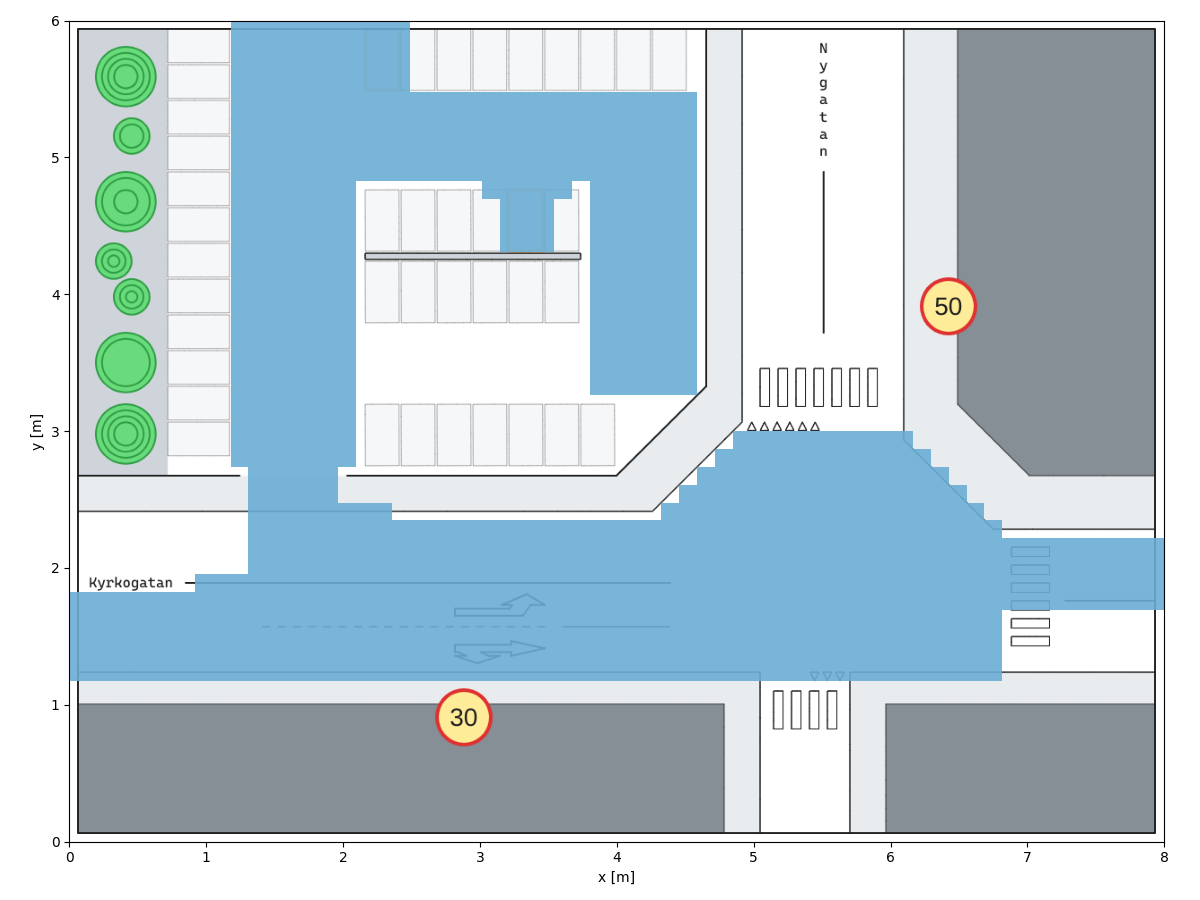

In [8]:
fig = new_map(
    (shp.project_onto(out.vf, 1, 2), dict(cmap='Blues')),
)
# fig.gca().plot(traj[:, 2], traj[:, 3], 'ro')

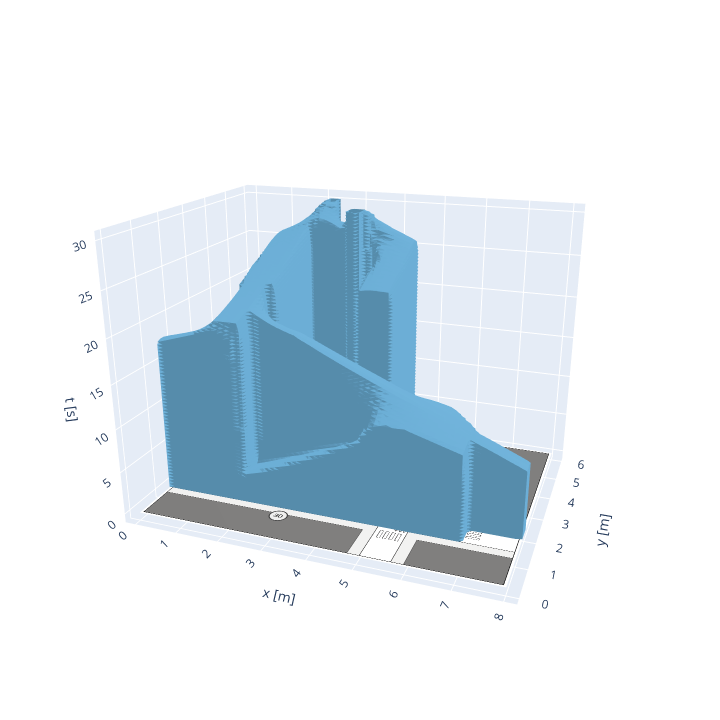

In [11]:
I, F = interact_tubes(
    timeline,
    ('Blues',   out.vf, dict(opacity=1)),
    eye=EYE_SSE,
    # axis=4,
)
fig = F()
# fig.add_scatter3d(x=traj[:, 2], y=traj[:, 3], z=traj[:, 4], mode='lines+markers', marker=dict(size=3)),
# fig.show(config=dict(toImageButtonOptions=dict(height=720, width=720, scale=6)))
Image(fig.to_image(format='png'))

[1.5, 2.8, 1.6, 0, 0.6]


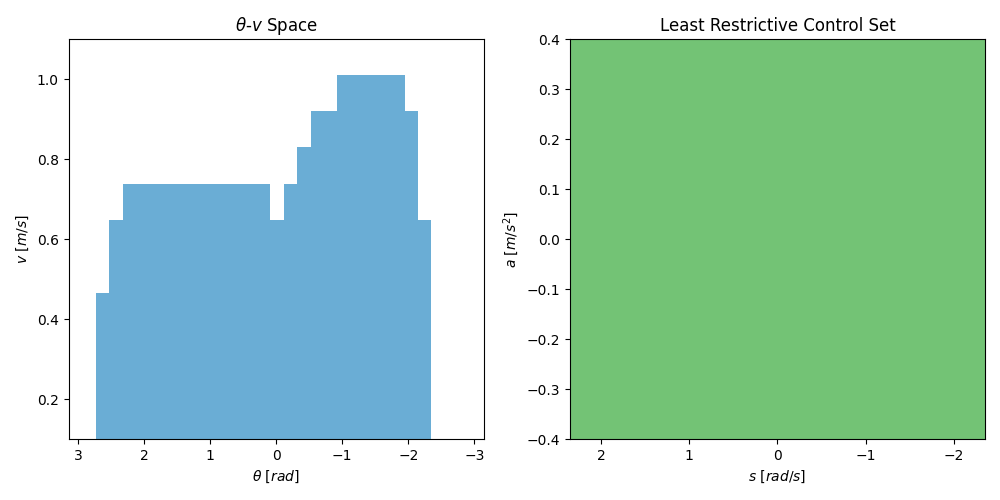

In [10]:
# x0 = [2, 1.5, 0, 0, 0.7]
# x0 = [5.6, 0.4, 1.8, 0, 0.4]
# x0 = [5.55396877,  1.35310905,  1.64714235, -0.47123891,  0.48000001] # problematic

i, x = 15, [0.4, 1.6, 0, 0, 0.5] # x0
i, x = 45, [1.5, 2.8, 1.6, 0, 0.6] # x1
# i, x = 108, [3.9, 3.9, 0.2, 0, 0.4] # x2
# i, x = 142, [2.5, 5.5, 2.5, 0, 0.4] # x3

# # # # # # # # # # # # #

print(x)
ix = nearest_index(grid, x)
extent = [-np.pi, +np.pi, 0.1, 1.1]
fig, (lax, rax) = plt.subplots(ncols=2, figsize=(10,5))
# Left Plot
plot_im(shp.project_onto(out.vf[i:, ix[0], ix[1], :, ix[3], :], 1, 2) <= 0, ax=lax, extent=extent)
lax.set_title(r'$\theta$-$v$ Space')
lax.set_xlabel(r'$\theta$ $[rad]$')
lax.set_ylabel(r'$v$ $[m/s]$')
lax.invert_xaxis()
# Right Plot
a, b = lrcs(reach_dynamics, grid, 0.1, out.vf, x, i)
xs, ys = np.meshgrid(np.linspace(-3*np.pi/4, 3*np.pi/4), np.linspace(-0.4, 0.4))
extent = [xs.min(), xs.max(), ys.min(), ys.max()]
plot_im(a + b[0]*xs + b[1]*ys <= 0, ax=rax, transpose=False, extent=extent, cmap='Greens')
rax.set_title('Least Restrictive Control Set')
rax.set_xlabel(r'$s$ $[rad/s]$')
rax.set_ylabel(r'$a$ $[m/s^2]$')
rax.invert_xaxis()
fig.tight_layout()